## Face Hallucination

The goal is given low resolution of a face, we produced a higher resolution version of the input image.

The current version is taking 44x44 input image (we skip 22x22 version of image first).

This project is based on *Sam Witteveen's work on Super-resolution*, and modified accordingly for face hallucination purpose.

The bcolz dataset used in this training is [44x44](https://1drv.ms/u/s!ArIKNjDOB13ch3EacToq2ZKle8Pn) and [176x176](https://1drv.ms/u/s!ArIKNjDOB13ch3JgxEoiXhZWDdXH)

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image

import os
import sys
import bcolz
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
import keras.initializers as initializations
import keras.backend as K

from keras_tqdm import TQDMNotebookCallback

from keras.callbacks import CSVLogger
from keras.applications.resnet50 import ResNet50, decode_predictions, conv_block, identity_block
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, BatchNormalization, Activation, Lambda
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Model
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils import to_categorical, multi_gpu_model

from resizeimage import resizeimage
import glob
from vgg16_avg import VGG16_Avg

In [2]:
print('TensorFlow:',tf.__version__)
print('Keras:',keras.__version__)

TensorFlow: 1.4.0
Keras: 2.1.1


### Load prepared bcolz dataset 

We make use of the prepared bcolz dataset from the make_dataset_2 and make_dataset_3. (44x44 and 176x176) using 5000 dataset

In [3]:
def load_array(fname): return bcolz.open(fname)[0:5000] # training
def load_array3(fname): return bcolz.open(fname)[5000:6000] # test for unseen faces from celeb database

In [4]:
dpath = 'd:/desktop/'
bcolz_hr = 'dataset_176_bc'
bcolz_lr = 'dataset_44_bc'
bcolz_test_hr = 'dataset_176_bc'
bcolz_test_lr = 'dataset_44_bc'

arr_hr = load_array(dpath+bcolz_hr)
arr_lr = load_array(dpath+bcolz_lr)
arr_test_hr = load_array3(dpath+bcolz_test_hr)
arr_test_lr = load_array3(dpath+bcolz_test_lr)

### Create the preprocessing function

Subtract input image with predefined mean image.

In [5]:
# vgg preproc
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

### Defines building block for the networks

They are convolution blocks, res blocks, up-sampling  (or transposed convolution) and upsampling 4x function.

It is noted here, some functions have been upgraded with Keras 2.+ from original work.

In [6]:
# convolution blocks
def conv_block(x, num_filters, filter_size, stride=(2,2), mode='same', act=True):
    x = Conv2D(num_filters, (filter_size, filter_size), strides=stride, padding=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

# res block
def res_block(initial_input, num_filters=64):
    x = conv_block(initial_input, num_filters, 3, (1,1))
    x = conv_block(x, num_filters, 3, (1,1), act=False)
    return keras.layers.add([x, initial_input])

# Up Sampling block aka Decon
def up_block(x, num_filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Conv2D(num_filters, (size, size), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

# upsampling block
def get_upsampling_model_4x(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Conv2D(3, (9, 9), activation='tanh', padding='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

### The model

The model that produces the upsampled output

In [7]:
upsampled_inp,upsampled_output = get_upsampling_model_4x(arr_lr)

it_model = Model(upsampled_inp,upsampled_output)
it_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 44, 44, 64)   15616       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 44, 44, 64)   256         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 44, 44, 64)   0           batch_normalization_26[0][0]     
__________________________________________________________________________________________________
conv2d_28 

We make us of VGG16 to be used for loss function in our training -- *perceptual loss*

In [8]:
#vgg input
vgg_inp=Input(arr_hr.shape[1:])

#vgg network
vgg= VGG16(include_top=False, input_tensor=vgg_inp)
for l in vgg.layers: l.trainable=False

# Lambda makes a layer of a function/ this makes the preprocessing a layer
preproc_layer = Lambda(preproc)

# get the vgg output 
vgg_out_layer = vgg.get_layer('block2_conv2').output

# making model Model(inputs, outputs)
vgg_content = Model(vgg_inp, vgg_out_layer)

# this is the VGG model with the HR input
vgg_hr_image = vgg_content(preproc_layer(vgg_inp))

# this is the upsampled network
vgg_it_op = vgg_content(preproc_layer(upsampled_output))

# perceptual loss
loss = Lambda(lambda x: K.sqrt(K.mean((x[0]-x[1])**2, (1,2))))([vgg_hr_image, vgg_it_op])

The model for training ..

In [9]:
# model for training with perceptual loss
sr_model = Model([upsampled_inp, vgg_inp], loss)

# we use two GPU Tesla K-80 (google cloud instance) for this training
parallel_model = multi_gpu_model(sr_model, gpus=2)

# sr_model.compile(loss = 'mse', optimizer = keras.optimizers.Adam())
parallel_model.compile( loss = 'mse', optimizer = keras.optimizers.Adam())

# history
H3 = {}

# target
targ = np.zeros((arr_hr.shape[0], 128)) # mean value at 128

### Training the model

The below snippet is shown only for 50 epoch, prior to that it has been trained over 200 epochs so total is about 250 epochs with batch size of 128 using two GPUS (5000 samples).


In [10]:
try:
    # 1) history = parallel_model.fit([arr_lr, arr_hr], targ, batch_size = 128, epochs = 200, verbose = 1)

    history = parallel_model.fit([arr_lr, arr_hr], targ, batch_size = 128, epochs = 50, verbose = 1)
    
    H3 = history.history
except KeyboardInterrupt:
    # H3 = sr_model.history.history
    H3 = parallel_model.history.history
    print(' .. >> stopping.')
    pass

parallel_model.save_weights('par5k_02.h5')
it_model = Model(upsampled_inp, upsampled_output)
it_model.save_weights('parmodel_4x_02.h5')

Epoch 1/50

5000/5000 [==============================] - ETA: 0s - loss: 25665.0526
Epoch 2/50

5000/5000 [==============================] - ETA: 0s - loss: 25587.6949
Epoch 3/50

5000/5000 [==============================] - ETA: 0s - loss: 25570.0809
Epoch 4/50

5000/5000 [==============================] - ETA: 0s - loss: 25542.8703
Epoch 5/50

5000/5000 [==============================] - ETA: 0s - loss: 25742.4834
Epoch 6/50

2816/5000 [===============>..............] - ETA: 32s - loss: 25544.1689


5000/5000 [==============================] - ETA: 0s - loss: 25490.5877
Epoch 7/50

5000/5000 [==============================] - ETA: 0s - loss: 25496.5743
Epoch 8/50

5000/5000 [==============================] - ETA: 0s - loss: 25316.6281
Epoch 9/50

5000/5000 [==============================] - ETA: 0s - loss: 25593.2952
Epoch 10/50

5000/5000 [==============================] - ETA: 0s - loss: 25417.1942
Epoch 11/50

5000/5000 [==============================] - ETA: 0s - loss: 25338.7462
Epoch 12/50

 512/5000 [==>...........................] - ETA: 1:05 - loss: 25906.7681


5000/5000 [==============================] - ETA: 0s - loss: 25251.0240
Epoch 13/50

5000/5000 [==============================] - ETA: 0s - loss: 25253.4999
Epoch 14/50

5000/5000 [==============================] - ETA: 0s - loss: 25431.9794
Epoch 15/50

5000/5000 [==============================] - ETA: 0s - loss: 25268.1601
Epoch 16/50

5000/5000 [==============================] - ETA: 0s - loss: 25217.9088
Epoch 17/50

3328/5000 [==================>...........] - ETA: 24s - loss: 25234.8057


5000/5000 [==============================] - ETA: 0s - loss: 25172.3677
Epoch 18/50

5000/5000 [==============================] - ETA: 0s - loss: 25158.3602
Epoch 19/50

5000/5000 [==============================] - ETA: 0s - loss: 25574.8056
Epoch 20/50

5000/5000 [==============================] - ETA: 0s - loss: 25260.2657
Epoch 21/50

5000/5000 [==============================] - ETA: 0s - loss: 25100.6814
Epoch 22/50

5000/5000 [==============================] - ETA: 0s - loss: 25101.4334
Epoch 23/50

1024/5000 [=====>........................] - ETA: 57s - loss: 24795.9863


5000/5000 [==============================] - ETA: 0s - loss: 25078.3372
Epoch 24/50

5000/5000 [==============================] - ETA: 0s - loss: 27516.8150
Epoch 25/50

5000/5000 [==============================] - ETA: 0s - loss: 25919.9567


Epoch 26/50

5000/5000 [==============================] - ETA: 0s - loss: 25639.5431
Epoch 27/50

5000/5000 [==============================] - ETA: 0s - loss: 25485.6604
Epoch 28/50

5000/5000 [==============================] - ETA: 0s - loss: 25447.0593
Epoch 29/50

5000/5000 [==============================] - ETA: 0s - loss: 25278.5280
Epoch 30/50

5000/5000 [==============================] - ETA: 0s - loss: 25288.4993
Epoch 31/50

2816/5000 [===============>..............] - ETA: 32s - loss: 25269.0088


5000/5000 [==============================] - ETA: 0s - loss: 25254.0444
Epoch 32/50

5000/5000 [==============================] - ETA: 0s - loss: 25384.5410
Epoch 33/50

5000/5000 [==============================] - ETA: 0s - loss: 25046.7016
Epoch 34/50

5000/5000 [==============================] - ETA: 0s - loss: 24916.0869
Epoch 36/50

5000/5000 [==============================] - ETA: 0s - loss: 25045.8923
Epoch 37/50

1280/5000 [======>.......................] - ETA: 55s - loss: 24745.3127


5000/5000 [==============================] - ETA: 0s - loss: 24830.7685
Epoch 38/50

5000/5000 [==============================] - ETA: 0s - loss: 24899.1840
Epoch 39/50

5000/5000 [==============================] - ETA: 0s - loss: 24861.9371
Epoch 40/50

5000/5000 [==============================] - ETA: 0s - loss: 25053.4427
Epoch 41/50

5000/5000 [==============================] - ETA: 0s - loss: 24796.8460
Epoch 42/50

4096/5000 [=======================>......] - ETA: 13s - loss: 24648.2485


5000/5000 [==============================] - ETA: 0s - loss: 24654.8306
Epoch 43/50

5000/5000 [==============================] - ETA: 0s - loss: 24846.6234
Epoch 44/50

5000/5000 [==============================] - ETA: 0s - loss: 24894.7744
Epoch 45/50

5000/5000 [==============================] - ETA: 0s - loss: 29740.8272
Epoch 46/50

5000/5000 [==============================] - ETA: 0s - loss: 26362.1643
Epoch 47/50

5000/5000 [==============================] - ETA: 0s - loss: 26003.9730
Epoch 48/50

1792/5000 [=========>....................] - ETA: 46s - loss: 33898.5831


5000/5000 [==============================] - ETA: 0s - loss: 30485.7062
Epoch 49/50

5000/5000 [==============================] - ETA: 0s - loss: 26907.0055
Epoch 50/50

5000/5000 [==============================] - ETA: 0s - loss: 26232.5027


0

### Evaluate and make predictions

we make predictions and evaluate the result of our model..

In [12]:
it_model = Model(upsampled_inp, upsampled_output)
it_model.load_weights('parmodel_4x_01.h5')

In [13]:
%time p = it_model.predict(arr_lr[4000:4050])
p.shape

Wall time: 169 ms


(50, 176, 176, 3)

In [15]:
def compare_pics(x,y,z):
    fig = plt.figure(figsize=(30,30))
    a=fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x)
    a=fig.add_subplot(1,3,2)
    imgplot = plt.imshow(y)
    a=fig.add_subplot(1,3,3)
    imgplot = plt.imshow(z)

Below, **Left**: Low-resolution input (44x44),   **Middle**: Result of our hallucination,   **Right**: Ground-truth (176x176) using our **Training data**

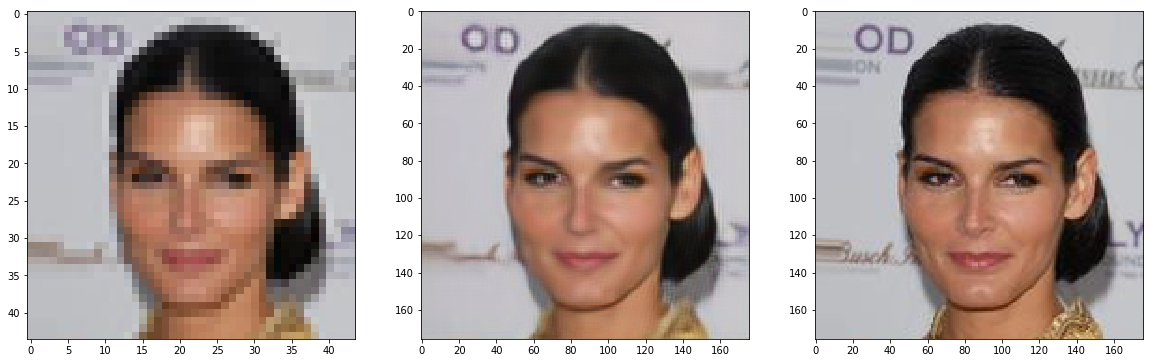

In [16]:
id = 4030
compare_pics(arr_lr[id].astype('uint8'), p[id-4000].astype('uint8'), arr_hr[id].astype('uint8'))


We test with our test data..

In [18]:
%time p = it_model.predict(arr_test_lr[0:100])
p.shape

Wall time: 469 ms


(100, 176, 176, 3)

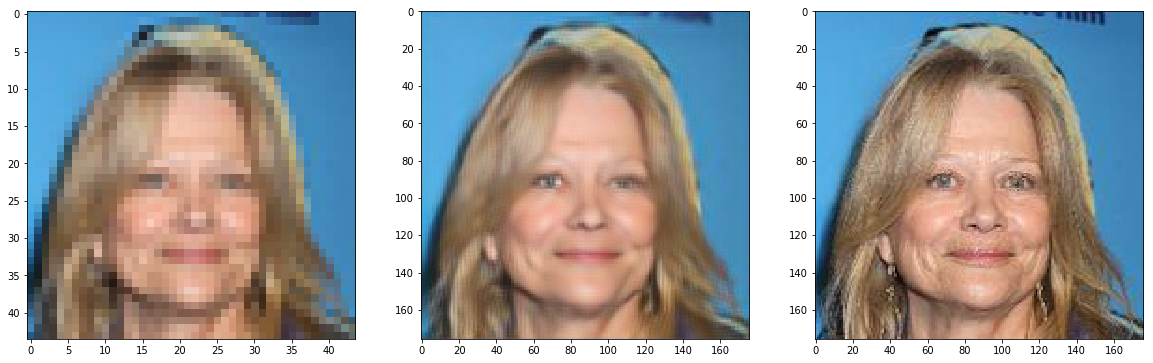

In [20]:
id = 50
compare_pics(arr_test_lr[id].astype('uint8'), p[id].astype('uint8'), arr_test_hr[id].astype('uint8'))

Another result ..

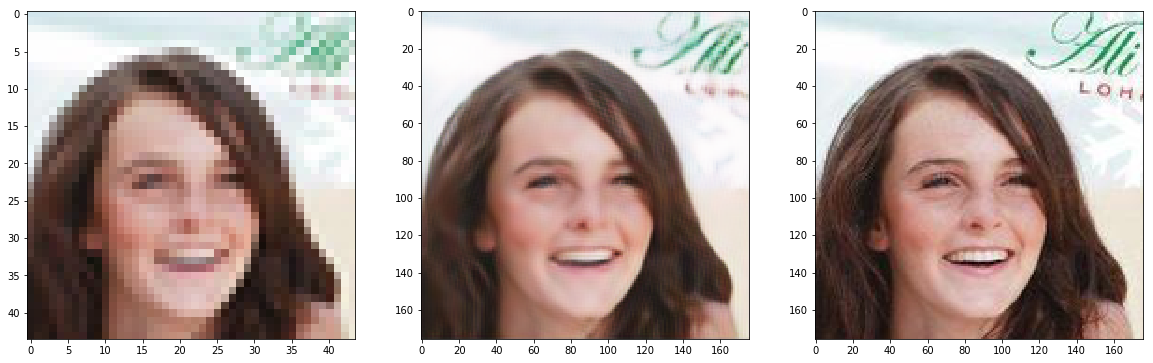

In [21]:
id = 8
compare_pics(arr_test_lr[id].astype('uint8'), p[id].astype('uint8'), arr_test_hr[id].astype('uint8'))


If we combine with some post-processing on image by image sharpening, we can get better result..


In [22]:
import cv2
def sharpen_image(img):
    img1 = img
    img2 = cv2.GaussianBlur(img1, (0,0), 5.0)
    img3 = cv2.addWeighted(img1, 1.5, img2, -0.5, 0, img1)
    return img3

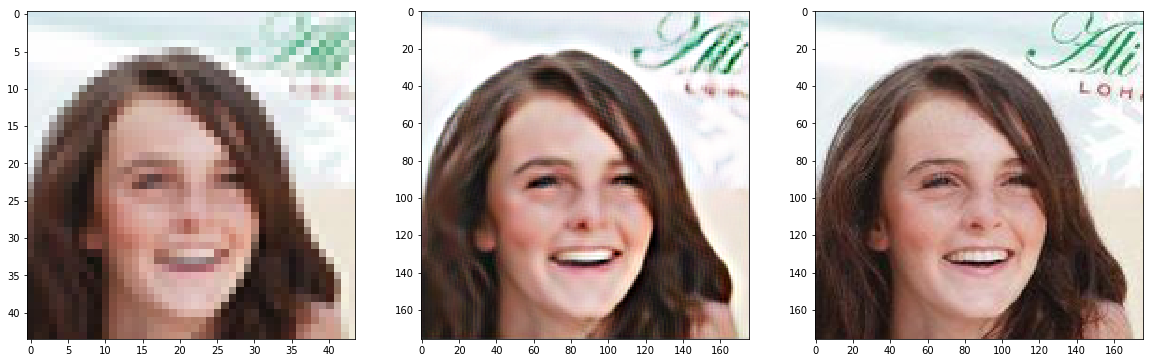

In [23]:
compare_pics(arr_test_lr[id].astype('uint8'), sharpen_image(p[id].astype('uint8')), arr_test_hr[id].astype('uint8'))


### Conclusions

The face hallucination using super-resolution technique has been demonstrated, and in this case, 4x up-sampling is used. 

The result is comparably similar to the ground truth, but there is some smoothing over the skin. Some details on hair and teeth are not shown yet.

The improvement can be made by increasing the number of epochs for the training, and also to consider better model.